In [9]:
# %% [markdown]
# # FAE Latent MSBM: Latent Manifold + Trajectory Visualization
#
# This notebook visualizes MSBM trajectories **in the latent space of a pretrained (time-invariant) Functional Autoencoder (FAE)**.
#
# It expects artifacts produced by:
# - `scripts/fae/fae_naive/train_latent_msbm.py`
#
# Key visuals:
# - 2D/3D latent "manifold" (via PCA) of the encoded time marginals
# - Forward/backward MSBM trajectories overlaid in the same embedding
#
# Notes
# -----
# - The FAE latent codes are time-invariant (encoder has no time input), but the dataset is time-marginalized.
# - MSBM policies act in latent space; we visualize their sampled trajectories relative to the marginal clouds.

In [10]:
from __future__ import annotations

import sys
from dataclasses import dataclass
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import cm
from matplotlib.collections import LineCollection

# Make repo importable when running from `notebooks/`
path_root = Path.cwd().parent
if str(path_root) not in sys.path:
    sys.path.insert(0, str(path_root))

from scripts.images.field_visualization import format_for_paper
from scripts.pca.pca_visualization_utils import parse_args_file

print("Imports successful!")

Imports successful!


/home/jy384/miniconda3/envs/3MASB/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/jy384/miniconda3/envs/3MASB/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened becau

In [11]:
format_for_paper()

# %% [markdown]
# ## Configuration
#
# Point `msbm_dir` at a run directory created by `train_latent_msbm.py` (under `results/`).

In [12]:
msbm_dir = Path("/data1/jy384/research/MMSFM/results/fae_latent_msbm_var0625_clip2")

# Which split to visualize as the latent manifold.
manifold_split = "test"  # {"train", "test"}

# PCA embedding settings (kept lightweight).
embed_dim = 2  # 2 or 3 (effective dim is min(embed_dim, latent_dim))
max_fit_points = 20000
points_per_time = 800

# Trajectory overlay settings
n_traj_plot = 30
traj_source = "auto"  # {"auto", "final", "eval_stage"}
eval_stage = None  # e.g. 10 to load results/<run>/eval/stage_0010/eval_samples.npz

seed = 42

viz_dir = msbm_dir / "eval" / "latent_viz"
viz_dir.mkdir(parents=True, exist_ok=True)
print(f"Saving figures to: {viz_dir}")

Saving figures to: /data1/jy384/research/MMSFM/results/fae_latent_msbm_var0625_clip2/eval/latent_viz


In [13]:
if not msbm_dir.exists():
    raise FileNotFoundError(f"msbm_dir does not exist: {msbm_dir}")

args_path = msbm_dir / "args.txt"
train_cfg = parse_args_file(args_path) if args_path.exists() else {}
print(f"Loaded args: {bool(train_cfg)} ({args_path if args_path.exists() else 'missing'})")

# %% [markdown]
# ## Load latent marginals (FAE encodings)
#
# `fae_latents.npz` is written by `train_latent_msbm.py` and contains:
# - `latent_train`: (T, N_train, K)
# - `latent_test`:  (T, N_test, K)
# - `zt`: (T,)

Loaded args: True (/data1/jy384/research/MMSFM/results/fae_latent_msbm_var0625_clip2/args.txt)


In [14]:
latents_path = msbm_dir / "fae_latents.npz"
if not latents_path.exists():
    raise FileNotFoundError(
        f"Missing {latents_path}. Run `scripts/fae/fae_naive/train_latent_msbm.py` first."
    )

lat_npz = np.load(latents_path, allow_pickle=True)
latent_train = np.asarray(lat_npz["latent_train"], dtype=np.float32)
latent_test = np.asarray(lat_npz["latent_test"], dtype=np.float32)
zt = np.asarray(lat_npz["zt"], dtype=np.float32)
time_indices = np.asarray(lat_npz["time_indices"], dtype=np.int64) if "time_indices" in lat_npz else None

split = None
if "split" in lat_npz:
    try:
        split = lat_npz["split"].item()
    except Exception:
        split = None

lat_npz.close()

T, n_train, latent_dim = latent_train.shape
_, n_test, _ = latent_test.shape
print(f"T={T}  latent_dim={latent_dim}")
print(f"latent_train: {latent_train.shape}  latent_test: {latent_test.shape}")
print(f"zt: {np.round(zt, 4).tolist()}")

embed_dim_eff = int(min(int(embed_dim), int(latent_dim)))
if embed_dim_eff != int(embed_dim):
    print(f"Note: requested embed_dim={embed_dim}, but latent_dim={latent_dim}; using embed_dim_eff={embed_dim_eff}.")

# %% [markdown]
# ## Load generated latent trajectories (forward/backward)
#
# This notebook will try, in order:
# 1) `msbm_decoded_samples.npz` (final sampling written at the end of training)
# 2) the latest `eval/stage_XXXX/eval_samples.npz`
#
# You can force either source via `traj_source`.

T=5  latent_dim=256
latent_train: (5, 4000, 256)  latent_test: (5, 1000, 256)
zt: [0.0, 0.33329999446868896, 0.5, 0.833299994468689, 1.0]


In [15]:
def _find_latest_eval_npz(run_dir: Path) -> Optional[Path]:
    eval_root = run_dir / "eval"
    if not eval_root.exists():
        return None
    candidates = sorted(eval_root.glob("stage_*/eval_samples.npz"))
    return candidates[-1] if candidates else None


def _resolve_traj_npz(run_dir: Path, *, source: str, stage: Optional[int]) -> Optional[Path]:
    final_path = run_dir / "msbm_decoded_samples.npz"
    if source == "final":
        return final_path if final_path.exists() else None
    if source == "eval_stage":
        if stage is None:
            raise ValueError("traj_source='eval_stage' requires eval_stage=<int>.")
        cand = run_dir / "eval" / f"stage_{int(stage):04d}" / "eval_samples.npz"
        return cand if cand.exists() else None
    # source == "auto"
    if final_path.exists():
        return final_path
    return _find_latest_eval_npz(run_dir)


traj_path = _resolve_traj_npz(msbm_dir, source=traj_source, stage=eval_stage)
latent_forward = None
latent_backward = None
traj_zt = zt

if traj_path is None:
    print(
        "Could not find latent trajectory samples. Expected one of:\n"
        f"- {msbm_dir / 'msbm_decoded_samples.npz'}\n"
        f"- {msbm_dir / 'eval' / 'stage_XXXX' / 'eval_samples.npz'}\n\n"
        "Re-run training with `--n_decode > 0` and/or `--eval_interval_stages > 0` to generate them."
    )
else:
    traj_npz = np.load(traj_path, allow_pickle=True)
    latent_forward = np.asarray(traj_npz["latent_forward"], dtype=np.float32) if "latent_forward" in traj_npz else None
    latent_backward = np.asarray(traj_npz["latent_backward"], dtype=np.float32) if "latent_backward" in traj_npz else None
    traj_zt = np.asarray(traj_npz["zt"], dtype=np.float32) if "zt" in traj_npz else zt
    traj_npz.close()

    print(f"Loaded trajectories from: {traj_path}")
    print(f"latent_forward: {None if latent_forward is None else latent_forward.shape}")
    print(f"latent_backward: {None if latent_backward is None else latent_backward.shape}")

# %% [markdown]
# ## PCA embedding (latent manifold)
#
# We fit PCA on a subsample of latent points across all time marginals (and optionally the trajectories),
# then project:
# - the marginal clouds
# - the generated trajectories

Loaded trajectories from: /data1/jy384/research/MMSFM/results/fae_latent_msbm_var0625_clip2/msbm_decoded_samples.npz
latent_forward: (5, 128, 256)
latent_backward: (5, 128, 256)


In [16]:
@dataclass
class LinearEmbedding:
    mean: np.ndarray  # (K,)
    components: np.ndarray  # (D, K) where D=embed_dim

    def transform(self, x: np.ndarray) -> np.ndarray:
        x2 = x.reshape(-1, x.shape[-1]).astype(np.float32, copy=False)
        y = (x2 - self.mean[None, :]) @ self.components.T
        return y.reshape(*x.shape[:-1], self.components.shape[0])


def _fit_pca_embedding(
    latents: np.ndarray,  # (T,N,K)
    *,
    dim: int,
    max_points: int,
    seed: int,
    extra: Optional[np.ndarray] = None,
) -> LinearEmbedding:
    rng = np.random.default_rng(int(seed))
    T, N, K = latents.shape

    x = latents.reshape(T * N, K)
    take = min(int(max_points), x.shape[0])
    idx = rng.choice(x.shape[0], size=take, replace=False)
    fit = x[idx]
    if extra is not None:
        fit = np.concatenate([fit, extra.reshape(-1, K)], axis=0)

    try:
        from sklearn.decomposition import PCA

        pca = PCA(n_components=int(dim), random_state=int(seed))
        pca.fit(fit)
        mean = pca.mean_.astype(np.float32)
        comps = pca.components_.astype(np.float32)
        explained = getattr(pca, "explained_variance_ratio_", None)
        if explained is not None:
            print(f"PCA explained variance ratio: {np.round(explained, 4).tolist()}")
        return LinearEmbedding(mean=mean, components=comps)
    except Exception:
        # Numpy fallback: PCA via SVD of centered samples.
        fit = fit.astype(np.float32, copy=False)
        mean = fit.mean(axis=0)
        x0 = fit - mean[None, :]
        _, _, vt = np.linalg.svd(x0, full_matrices=False)
        comps = vt[: int(dim)].astype(np.float32, copy=False)
        return LinearEmbedding(mean=mean.astype(np.float32), components=comps)


def _subsample_per_time(latents: np.ndarray, n: int, seed: int) -> np.ndarray:
    rng = np.random.default_rng(int(seed))
    T, N, K = latents.shape
    n_use = min(int(n), int(N))
    out = []
    for t in range(T):
        idx = rng.choice(N, size=n_use, replace=False)
        out.append(latents[t, idx])
    return np.stack(out, axis=0)


if manifold_split not in {"train", "test"}:
    raise ValueError("manifold_split must be 'train' or 'test'")
latent_for_manifold = latent_test if manifold_split == "test" else latent_train

extra_fit = None
if latent_forward is not None:
    extra_fit = latent_forward.reshape(-1, latent_forward.shape[-1])
if latent_backward is not None:
    extra_fit = (
        extra_fit
        if extra_fit is None
        else np.concatenate([extra_fit, latent_backward.reshape(-1, latent_backward.shape[-1])], axis=0)
    )

if latent_dim <= embed_dim_eff:
    # Identity embedding for 2D/3D latents.
    emb = LinearEmbedding(
        mean=np.zeros((latent_dim,), dtype=np.float32),
        components=np.eye(latent_dim, dtype=np.float32)[:embed_dim_eff],
    )
else:
    emb = _fit_pca_embedding(
        latent_for_manifold,
        dim=embed_dim_eff,
        max_points=max_fit_points,
        seed=seed,
        extra=extra_fit,
    )

latent_sub = _subsample_per_time(latent_for_manifold, points_per_time, seed=seed)
latent_sub_e = emb.transform(latent_sub)  # (T,n,embed_dim)

traj_f_e = emb.transform(latent_forward) if latent_forward is not None else None
traj_b_e = emb.transform(latent_backward) if latent_backward is not None else None

print(f"Manifold points (subsample): {latent_sub_e.shape}")
if traj_f_e is not None:
    print(f"Forward trajectories (embedded): {traj_f_e.shape}")
if traj_b_e is not None:
    print(f"Backward trajectories (embedded): {traj_b_e.shape}")

# %% [markdown]
# ## Plot helpers

PCA explained variance ratio: [0.046300001442432404, 0.021299999207258224]
Manifold points (subsample): (5, 800, 2)
Forward trajectories (embedded): (5, 128, 2)
Backward trajectories (embedded): (5, 128, 2)


In [17]:
def _time_colors(times: np.ndarray, cmap_name: str = "viridis"):
    norm = plt.Normalize(vmin=float(times.min()), vmax=float(times.max()))
    cmap = cm.get_cmap(cmap_name)
    return norm, cmap


def plot_manifold_2d(
    latent_e: np.ndarray,  # (T,n,2)
    times: np.ndarray,  # (T,)
    *,
    title: str,
    alpha: float = 0.12,
    s: float = 6.0,
    cmap_name: str = "viridis",
):
    norm, cmap = _time_colors(times, cmap_name=cmap_name)
    fig, ax = plt.subplots(figsize=(7, 6))
    for t in range(latent_e.shape[0]):
        c = cmap(norm(float(times[t])))
        ax.scatter(latent_e[t, :, 0], latent_e[t, :, 1], s=s, alpha=alpha, color=c, linewidths=0.0)

    means = latent_e.mean(axis=1)
    ax.plot(means[:, 0], means[:, 1], color="black", lw=2.0, alpha=0.8, label="marginal mean path")
    ax.scatter(means[:, 0], means[:, 1], color="black", s=25, zorder=3)

    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cb = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label("time (zt)", rotation=90)

    ax.set_title(title)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.grid(True, alpha=0.2)
    ax.legend(loc="best")
    fig.tight_layout()
    return fig, ax


def plot_trajectories_2d(
    ax,
    traj_e: np.ndarray,  # (T,N,2)
    times: np.ndarray,  # (T,)
    *,
    n_plot: int,
    color: str = "tab:orange",
    lw: float = 1.2,
    alpha: float = 0.9,
    time_colored: bool = True,
    zorder: int = 5,
):
    if traj_e is None or traj_e.size == 0:
        return
    T, N, D = traj_e.shape
    if D != 2:
        raise ValueError("plot_trajectories_2d expects 2D embedded trajectories.")
    n_use = min(int(n_plot), int(N))

    if time_colored:
        norm, cmap = _time_colors(times, cmap_name="plasma")
        for j in range(n_use):
            pts = traj_e[:, j, :]
            segs = np.concatenate([pts[:-1, None, :], pts[1:, None, :]], axis=1)
            lc = LineCollection(segs, cmap=cmap, norm=norm, linewidths=lw, alpha=alpha, zorder=zorder)
            lc.set_array(times[:-1])
            ax.add_collection(lc)
            ax.scatter(pts[0, 0], pts[0, 1], s=18, color="white", edgecolor="black", linewidths=0.5, zorder=zorder + 1)
            ax.scatter(pts[-1, 0], pts[-1, 1], s=18, color="black", edgecolor="white", linewidths=0.5, zorder=zorder + 1)
    else:
        for j in range(n_use):
            pts = traj_e[:, j, :]
            ax.plot(pts[:, 0], pts[:, 1], color=color, lw=lw, alpha=alpha, zorder=zorder)


def plot_manifold_with_trajectories(
    latent_e: np.ndarray,
    times: np.ndarray,
    traj_f: Optional[np.ndarray],
    traj_b: Optional[np.ndarray],
    *,
    n_plot: int,
    title: str,
):
    fig, ax = plot_manifold_2d(latent_e, times, title=title)
    if traj_f is not None:
        plot_trajectories_2d(ax, traj_f, times, n_plot=n_plot, time_colored=True)
    if traj_b is not None:
        plot_trajectories_2d(ax, traj_b, times, n_plot=n_plot, time_colored=True)
    return fig, ax


# %% [markdown]
# ## Latent manifold (2D)

/tmp/ipykernel_3835942/3456488247.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


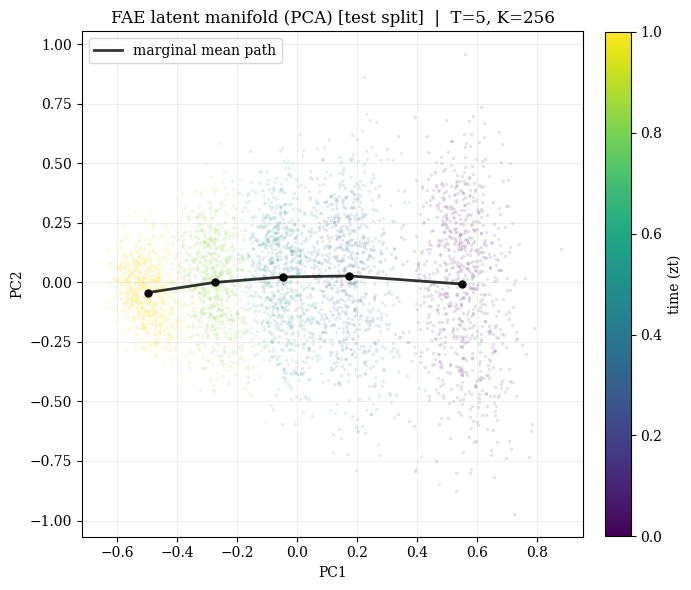

In [18]:
if embed_dim_eff != 2:
    print("Set embed_dim=2 to run the 2D manifold plots.")
else:
    fig, _ax = plot_manifold_2d(
        latent_sub_e,
        zt,
        title=f"FAE latent manifold (PCA) [{manifold_split} split]  |  T={T}, K={latent_dim}",
    )
    fig.savefig(viz_dir / "latent_manifold_2d.png", dpi=150)
    plt.show()

# %% [markdown]
# ## Latent manifold + MSBM trajectories (2D)

/tmp/ipykernel_3835942/3456488247.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


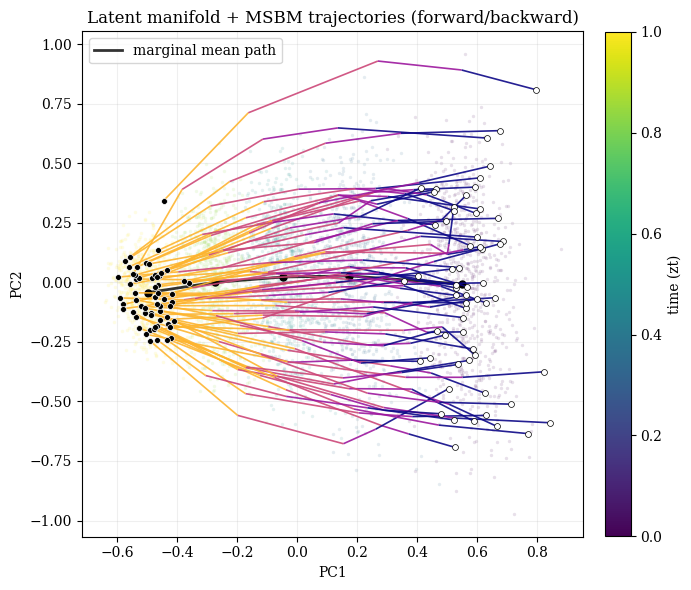

In [19]:
if embed_dim_eff != 2:
    print("Set embed_dim=2 to run the 2D trajectory overlay plots.")
else:
    fig, _ax = plot_manifold_with_trajectories(
        latent_sub_e,
        zt,
        traj_f_e,
        traj_b_e,
        n_plot=n_traj_plot,
        title="Latent manifold + MSBM trajectories (forward/backward)",
    )
    fig.savefig(viz_dir / "latent_manifold_with_trajectories_2d.png", dpi=150)
    plt.show()

# %% [markdown]
# ## Optional: 3D embedding
#
# Set `embed_dim=3` at the top to enable.

In [20]:
if embed_dim_eff == 3:
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(111, projection="3d")
    norm, cmap = _time_colors(zt)

    for t in range(latent_sub_e.shape[0]):
        c = cmap(norm(float(zt[t])))
        ax.scatter(
            latent_sub_e[t, :, 0],
            latent_sub_e[t, :, 1],
            latent_sub_e[t, :, 2],
            s=4,
            alpha=0.10,
            color=c,
        )

    means = latent_sub_e.mean(axis=1)
    ax.plot(means[:, 0], means[:, 1], means[:, 2], color="black", lw=2.0, alpha=0.9)

    def _plot_traj3(traj_e: Optional[np.ndarray], color: str):
        if traj_e is None:
            return
        n_use = min(int(n_traj_plot), int(traj_e.shape[1]))
        for j in range(n_use):
            pts = traj_e[:, j, :]
            ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], color=color, lw=1.0, alpha=0.8)

    _plot_traj3(traj_f_e, "tab:orange")
    _plot_traj3(traj_b_e, "tab:blue")

    ax.set_title("Latent manifold + trajectories (3D PCA)")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    fig.tight_layout()
    fig.savefig(viz_dir / "latent_manifold_with_trajectories_3d.png", dpi=150)
    plt.show()
